In [3]:
import os
import re

# from kinnara.gather.twitter import TwitterApiWrapper

In [2]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
        level=logging.INFO)
logger = logging.getLogger(__name__)

#### read in api keys and access tokens

In [3]:
api_key = os.getenv('API_KEY')
api_secret = os.getenv('API_SECRET')

access_token = os.getenv('ACCESS_TOKEN')
access_token_secret = os.getenv('ACCESS_TOKEN_SECRET')

## Gather public figure tweets

In [4]:
# create kinnara gatherer
twitter_wrapper = TwitterApiWrapper(api_key=api_key, api_secret=api_secret,
                        access_token=access_token, access_token_secret=access_token_secret)

In [10]:
screen_names = [
    'BarackObama',
    'realDonaldTrump',
    'KimKardashian',
    'BillGates',
    'Oprah',
    'justinbieber',
    'Beyonce',
    'TheRock'
]

In [11]:
users = []
for screen_name in screen_names:
    users.append(twitter_wrapper.get_user(screen_name))

2018-08-22 10:41:39,245 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:39,417 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:39,607 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:39,782 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:39,968 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:40,147 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:40,340 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:40,508 - INFO - Starting new HTTPS connection (1): api.twitter.com


In [12]:
# lets grab 400 tweets from each twitter users timeline
for user in users:
    user['tweets'] = twitter_wrapper.get_tweets(user['id_str'], max_tweets_returned=400)

2018-08-22 10:41:47,348 - INFO - getting tweets for 813286
2018-08-22 10:41:47,353 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:47,911 - INFO - getting tweets for 813286
2018-08-22 10:41:47,915 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:48,260 - INFO - getting tweets for 25073877
2018-08-22 10:41:48,264 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:48,611 - INFO - getting tweets for 25073877
2018-08-22 10:41:48,614 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:48,966 - INFO - getting tweets for 25365536
2018-08-22 10:41:48,970 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:49,352 - INFO - getting tweets for 25365536
2018-08-22 10:41:49,356 - INFO - Starting new HTTPS connection (1): api.twitter.com
2018-08-22 10:41:49,989 - INFO - getting tweets for 50393960
2018-08-22 10:41:49,993 - INFO - Starting new HTTPS connection (1): api.t

In [54]:
def clean_tweet(tweet_text):
    '''clean up tweet text'''
    return re.sub(r' ?https[^ ]*', r'', tweet_text)

In [57]:
screen_name_to_tweets = {}
for user in users:
    screen_name_to_tweets[user['screen_name']] = [clean_tweet(tweet.get('full_text', ''))
                                                  for tweet in user['tweets']
                                                  if re.match(r'^RT @', tweet['full_text']) is None]

In [61]:
# save it for later
f = open('tweet_data.csv', 'w')
for screen_name, tweets in screen_name_to_tweets.items():
    for tweet in tweets:
        f.write(f'"{screen_name}", "{tweet}"\n')
f.close()

# Model

This portion of the notebook borrows extensively from fast.ai's notebook for lesson 10 in their deep learning course part two.

In [4]:
import collections
import html

import numpy as np
import pandas as pd

from fastai.text import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Define the directories we'll be using

You'll need to download tweet sentiment data from kaggle - https://www.kaggle.com/c/twitter-sentiment-analysis2/data - and put it in the twitter/orignal directory

In [5]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

# path to our original tweet data from kaggle
PATH = '/home/ubuntu/data/twitter/original'

In [6]:
# path to our classification data
CLASSIFICATION_PATH = '/home/ubuntu/data/twitter/twitter_classification/'

# path to our language model
LANGUAGE_MODEL_PATH = '/home/ubuntu/data/twitter/twitter_language_model/'

start prepping our tweet data from kaggle

In [7]:
CLASSES = ['neg', 'pos']

In [44]:
df = pd.read_csv(PATH + '/train.csv', encoding='latin1')

# shuffle rows and throw out item id column
df = df.drop('ItemID', axis=1)
df = df.sample(frac=1)

# rename columns
df.columns = ['labels', 'text']

# split datafram into train and validation sets for later
split_index = int(df.shape[0] * .9)
train_df, test_df = np.split(df, [split_index], axis=0)

saving our current progress

In [51]:
# save to classification directory
train_df.to_csv(CLASSIFICATION_PATH + '/train.csv', header=False, index=False, encoding='utf-8')
test_df.to_csv(CLASSIFICATION_PATH + '/test.csv', header=False, index=False, encoding='utf-8')

f = open(CLASSIFICATION_PATH + '/classes.txt', 'w', encoding='utf-8')
f.writelines(f'{c}\n' for c in CLASSES)
f.close()

# save to language model directory
# we should be adding in the test.csv from the kaggle competition here because the language model doesn't care about labels
# but in the interest of time I'm opting to just use the training set for the language model
train_df.to_csv(LANGUAGE_MODEL_PATH + '/train.csv', header=False, index=False, encoding='utf-8')
test_df.to_csv(LANGUAGE_MODEL_PATH + '/test.csv', header=False, index=False, encoding='utf-8')

lets start cleaning some text

In [9]:
# chunksize for pandas so it doesn't run into any memory limits
chunksize=24000

In [21]:
df.shape

(399978, 3)

In [12]:
## functions pulled from the fast.ai notebook for text tokenization

re1 = re.compile(r'  +')

def fixup(x):
    '''some patterns identified by the fast.ai folks that spacy doesn't account for'''
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

def get_all(df, n_lbls):
    '''tokenize the text'''
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [55]:
# grab our dataframes from earlier
train_df = pd.read_csv(LANGUAGE_MODEL_PATH + '/train.csv', header=None, chunksize=chunksize)
val_df = pd.read_csv(LANGUAGE_MODEL_PATH + '/test.csv', header=None, chunksize=chunksize)

In [58]:
# tokenize the tweets
train_tokens, train_labels = get_all(train_df, 1)
val_tokens, val_labels = get_all(val_df, 1)

0
1
2
0


In [59]:
#make temporary directory
os.mkdir(LANGUAGE_MODEL_PATH + '/tmp')

In [60]:
# save our tokens
np.save(LANGUAGE_MODEL_PATH + '/tmp/tok_trn.npy', train_tokens)
np.save(LANGUAGE_MODEL_PATH + '/tmp/tok_val.npy', val_tokens)

In [61]:
# load back in
train_tokens = np.load(LANGUAGE_MODEL_PATH + '/tmp/tok_trn.npy')
val_tokens = np.load(LANGUAGE_MODEL_PATH + '/tmp/tok_val.npy')

In [62]:
# lets take a look at our most common tokens
freq = Counter(token for tokens in train_tokens for token in tokens)
freq.most_common(25)

[('1', 66430),
 ('\n', 65991),
 ('xbos', 65990),
 ('xfld', 65990),
 ('i', 43568),
 ('.', 35466),
 ('!', 34347),
 (',', 21327),
 ('you', 19798),
 ('the', 19773),
 ('to', 19439),
 ('a', 15205),
 ('it', 14649),
 ('t_up', 14145),
 ('?', 12673),
 ('and', 10838),
 ('that', 9618),
 ('&', 9561),
 ('...', 9464),
 ('my', 9214),
 ('is', 8400),
 ('for', 8315),
 ('/', 8095),
 ('in', 7924),
 ("'s", 7875)]

looks about right.  quick note to keep in mind - the "t_up" token isn't in the text its self, it is a marker indicating the following token is all uppercase.

fast.ai recommends that you only keep the 60,000 or so most common tokens. Reason being low frequency tokens don't help you learn a lot about a language.

We don't have that many tokens for our tweets, but it makes me feel good to put in anyways ...

In [65]:
max_vocab = 60000
min_freq = 2

int_to_token = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
int_to_token.insert(0, '_pad_')
int_to_token.insert(0, '_unk_')

In [67]:
token_to_int = collections.defaultdict(lambda: 0, {v: k for k, v in enumerate(int_to_token)})
len(int_to_token)

15833

In [68]:
train_lm = np.array([[token_to_int[o] for o in p] for p in train_tokens])
val_lm = np.array([[token_to_int[o] for o in p] for p in val_tokens])

In [70]:
# saving our progress
np.save(LANGUAGE_MODEL_PATH + '/tmp/trn_ids.npy', train_lm)
np.save(LANGUAGE_MODEL_PATH + '/tmp/val_ids.npy', val_lm)

pickle.dump(int_to_token, open(LANGUAGE_MODEL_PATH + '/tmp/itos.pkl', 'wb'))

In [71]:
# loading back in
train_lm = np.load(LANGUAGE_MODEL_PATH + '/tmp/trn_ids.npy')
val_lm = np.load(LANGUAGE_MODEL_PATH + '/tmp/val_ids.npy')
int_to_token = pickle.load(open(LANGUAGE_MODEL_PATH + '/tmp/itos.pkl', 'rb'))

In [86]:
num_twitter_tokens = len(int_to_token)
num_twitter_tokens, len(train_lm)

(15833, 65990)

### load in a pretrained language model trained on wikipedia text

run this line to download wikipedia model

In [74]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

In [75]:
# some stats from the wikepedia model
embedding_size, num_hidden, num_layers = 400,1150,3

In [76]:
PRE_PATH = '/home/ubuntu/data/twitter/original/models/wt103/'
PRE_LM_PATH = PRE_PATH + '/fwd_wt103.h5'

In [77]:
# grab the weights from the encoder
weights = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

The mean of the weights from layer 0 can be used to assign weights to tokens that exist in the wikipedia dataset but not in the twitter dataset

In [80]:
encoder_weights = to_np(weights['0.encoder.weight'])
# row_m = enc_wgts.mean(0)
encoder_mean = encoder_weights.mean(0)

In [85]:
wiki_int_to_token = pickle.load(open(PRE_PATH + '/itos_wt103.pkl', 'rb'))
wiki_token_to_int = collections.defaultdict(lambda: -1, {v:k for k, v in enumerate(wiki_int_to_token)})

We need to assign mean weights to tokens that exist in our twitter dataset that dont in the wikipedia dataset the pretrained model was trained on.

In [87]:
new_weights = np.zeros((num_twitter_tokens, embedding_size), dtype=np.float32)
for i, w in enumerate(int_to_token):
    r = wiki_token_to_int[w]
    new_weights[i] = encoder_weights[r] if r >= 0 else encoder_mean

We now need to put the new weights into the pretrained model

The weights between the encoder and decoder also need to be tied together

In [88]:
weights['0.encoder.weight'] = T(new_weights)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_weights))
weights['1.decoder.weight'] = T(np.copy(new_weights))

### Retraining the wikipedia language model

In [89]:
wd=1e-7 # weight decay
bptt=70 # ngram size.  i.e. the model sees ~70 tokens and then tries to predict the 71st
bs=52 # batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # optimazation function

Here we define a special fastai data loader, the `LanguageModelLoader`, to feed the training data into the model whilst training.

We can then use those to instanciate a `LanguageModelData` class that returns a fastai model we can train

In [90]:
train_dl = LanguageModelLoader(np.concatenate(train_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

md = LanguageModelData(PATH, 1, vs, train_dl, val_dl, bs=bs, bptt=bptt)

In [92]:
# the dropouts for each layer.
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

The last embedding layer needs to be tuned first so the new weights we set for the pretrained model get tuned properly.

fastai allows you to freeze and unfreeze model layers.  So here we freeze everything but the weights in the last embedding layer

In [93]:
learner = md.get_model(
    opt_fn, embedding_size, num_hidden, num_layers, dropouti=drops[0], dropout=drops[1],
    wdrop=drops[2], dropoute=drops[3], dropouth=drops[4]
)

learner.metrics = [accuracy]

# freeze everything except last layer
learner.freeze_to(-1)

In [94]:
# load the weights
learner.model.load_state_dict(weights)

In [95]:
lr = 1e-3 # learning rate
lrs = lr

In [97]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                   
    0      4.729706   4.402029   0.278313  
    1      4.451217   4.189084   0.309412                   



[array([4.18908]), 0.3094116130045482]

In [98]:
# save our progress
learner.save('lm_last_ft')

In [107]:
# load back in
learner.load('lm_last_ft')

In [108]:
# now with our new embedding weights trained up, we can unfreeze and train all layers
learner.unfreeze()

In [109]:
# to find our learning rate
learner.lr_find(start_lr=lrs/10, end_lr=lrs*50, linear=True)

epoch      trn_loss   val_loss   accuracy                   
    0      4.251524   4.190872   0.311685  



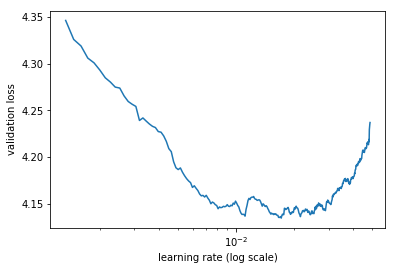

In [110]:
learner.sched.plot()

In [111]:
# looks like 10-2 or 10-3 or so could be a good learning rate for us

In [112]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      3.919195   3.718162   0.362635  



[array([3.71816]), 0.36263509414025713]

In [113]:
# save our progress
learner.save('lm1')
learner.save_encoder('lm1_enc')

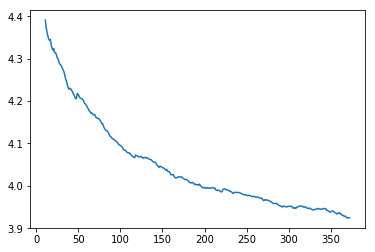

In [114]:
# taking a look at our loss
learner.sched.plot_loss()

## Tweet Sentiment Classifier

Now that we have our language model trained on tweets, we can start training our tweet sentiment classifier

To do this all we have to do is tack on a layer to our trained encoder.

In [10]:
train_df = pd.read_csv(CLASSIFICATION_PATH + '/train.csv', header=None, chunksize=chunksize)
val_df = pd.read_csv(CLASSIFICATION_PATH + '/test.csv', header=None, chunksize=chunksize)

In [13]:
# do the same cleaning we did for the language model
train_tokens, train_labels = get_all(train_df, 1)
val_tokens, val_labels = get_all(val_df, 1)

0
1
2
3
0


In [15]:
# make temp directory in classifier directory
os.mkdir(CLASSIFICATION_PATH + '/tmp')

# save tokens
np.save(CLASSIFICATION_PATH + '/tmp/tok_trn.npy', train_tokens)
np.save(CLASSIFICATION_PATH + '/tmp/tok_val.npy', val_tokens)

np.save(CLASSIFICATION_PATH + '/tmp/trn_labels.npy', train_labels)
np.save(CLASSIFICATION_PATH + '/tmp/val_labels.npy', val_labels)

In [61]:
# load back in 
train_tokens = np.load(CLASSIFICATION_PATH + '/tmp/tok_trn.npy')
val_tokens = np.load(CLASSIFICATION_PATH + '/tmp/tok_val.npy')

In [62]:
int_to_token = pickle.load(open(LANGUAGE_MODEL_PATH + '/tmp/itos.pkl', 'rb'))
token_to_int = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(int_to_token)})
len(int_to_token)

15833

In [63]:
train_classification = np.array([[token_to_int[o] for o in p] for p in train_tokens])
val_classification = np.array([[token_to_int[o] for o in p] for p in val_tokens])

In [64]:
np.save(CLASSIFICATION_PATH + '/tmp/trn_ids.npy', train_classification)
np.save(CLASSIFICATION_PATH + '/tmp/val_ids.npy', val_classification)

In [65]:
# load back in 
train_classification = np.load(CLASSIFICATION_PATH + '/tmp/trn_ids.npy')
val_classification = np.load(CLASSIFICATION_PATH + '/tmp/val_ids.npy')

train_labels = np.squeeze(np.load(CLASSIFICATION_PATH + '/tmp/trn_labels.npy'))
val_labels = np.squeeze(np.load(CLASSIFICATION_PATH + '/tmp/val_labels.npy'))

In [66]:
# params
bptt, embedding_size, num_hidden, num_layers = 70, 400, 1150, 3
num_tokens = len(int_to_token)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [67]:
train_classification[:5], train_labels[:5]

(array([list([3, 4, 5, 2, 0, 906, 9, 17, 107, 235, 562, 8, 82, 27, 1568, 11, 551, 50, 2180, 3293]),
        list([3, 4, 5, 2, 2239, 15, 143, 6, 15, 66, 15, 10, 9, 15, 10, 15, 48, 15, 299, 8, 8, 8, 289, 276]),
        list([3, 4, 5, 2, 3834, 145, 6285, 33, 0, 152, 124, 3382]),
        list([3, 4, 5, 2, 0, 0, 0, 100, 11, 5132, 7, 1080, 31, 51, 0, 25, 0, 7, 151, 54, 129, 2166, 130, 23, 11, 15, 0, 7]),
        list([3, 4, 5, 2, 0, 6, 39, 71, 457, 12, 198, 58, 261, 20, 61, 6, 73])], dtype=object),
 array([0, 1, 0, 1, 1]))

In [68]:
min_label = train_labels.min()
train_labels -= min_label
val_labels -= min_label
c = int(train_labels.max()) + 1

In [69]:
train_ds = TextDataset(train_classification, train_labels)
val_ds = TextDataset(val_classification, val_labels)

# the sortish sampler helps by sorting things kinda sorta by their token length so padding isn't crazy
train_sampler = SortishSampler(train_classification, key=lambda x: len(train_classification[x]), bs=bs//2)
# doesn't matter so much for the validation set
val_sampler = SortSampler(val_classification, key=lambda x: len(val_classification[x]))

# get data loaders
train_dl = DataLoader(train_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=train_sampler)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_sampler)

# model data
md = ModelData(PATH, train_dl, val_dl)

In [70]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [ ]:
# part 2
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [71]:
m = get_rnn_classifier(bptt, 20*70, c, num_tokens, emb_sz=embedding_size, n_hid=num_hidden, n_layers=num_layers,
                       pad_token=1, layers=[embedding_size*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0],
                       wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [72]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [73]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [74]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr]) # differential learning rates

In [31]:
# lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

load our encoder from our tweet language model

In [140]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [141]:
# freeze all except last layer
learn.freeze_to(-1)

 80%|███████▉  | 2996/3750 [02:02<00:30, 24.39it/s, loss=2.37] 

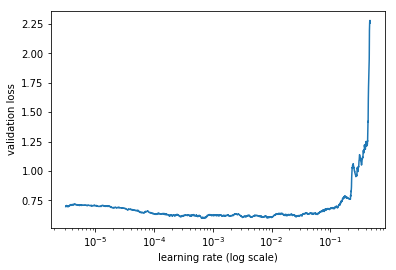

In [142]:
# to find learning rate
learn.lr_find(lrs/1000)
learn.sched.plot()

In [143]:
# little tough to tell here, but we'll go with what we set previously and what fastai used for their imdb dataset

In [144]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.607671   0.547222   0.718372  


[array([0.54722]), 0.7183718376963696]

In [145]:
# save our first classifier
learn.save('clas_0')

In [146]:
# load it back in
learn.load('clas_0')

In [147]:
# unfreeze one more layer
learn.freeze_to(-2)

In [148]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.567032   0.512081   0.744074  


[array([0.51208]), 0.7440744083349031]

In [149]:
# save our second classifier
learn.save('clas_1')

In [40]:
# load it back in
learn.load('clas_1')

In [151]:
# unfreeze all layers so we're training the whole network
learn.unfreeze()

In [152]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.510407   0.464771   0.778178  


[array([0.46477]), 0.7781778167683979]

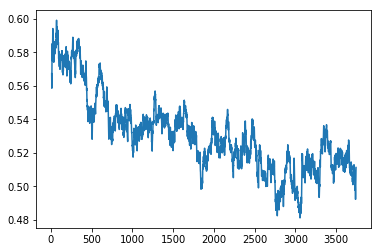

In [153]:
# plot out our loss
learn.sched.plot_loss()

In [154]:
# save our final classifier
learn.save('clas_2')

# Celebrity tweet sentiment

In [75]:
# load it back in
learn.load('clas_2')

In [77]:
log_predictions = learn.predict()

In [78]:
log_predictions[:10]

array([[-0.98515,  0.77511],
       [-0.65122,  0.2441 ],
       [ 0.20459, -0.21919],
       [-0.09927,  0.00084],
       [ 0.97675, -0.96793],
       [-0.57929,  0.22585],
       [-0.45396,  0.11646],
       [-1.15878,  1.3278 ],
       [-0.97455,  0.90879],
       [-0.19644,  0.12399]], dtype=float32)

In [79]:
preds = np.argmax(log_predictions, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_predictions[:,1])        # pr(dog)

In [80]:
preds[:10]

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1])

In [81]:
probs[:10]

array([2.17083, 1.27648, 0.80317, 1.00084, 0.37987, 1.25338, 1.12351, 3.77272, 2.48132, 1.13201],
      dtype=float32)

In [82]:
md.val_y[:10]

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1])

make data loader for predicting

In [58]:
md.val_ds.y[:10]

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [53]:
md.val_ds.x

array([list([3, 4, 5, 2, 0, 225, 6, 129, 249, 10, 219, 14, 14, 531, 5750, 55, 20]),
       list([3, 4, 5, 2, 0, 108, 10, 75, 7]),
       list([3, 4, 5, 2, 42, 699, 91, 11, 0, 420, 12, 177, 870, 49, 4495, 243]), ...,
       list([3, 4, 5, 2, 42, 0, 42, 0, 3405, 150, 141, 26, 2002, 359, 86, 43, 24, 24, 1210, 24, 0, 360, 9, 0, 1548, 87, 97, 0, 12, 0, 93, 759, 1443, 25, 1772, 7]),
       list([3, 4, 5, 2, 120, 0, 120, 6, 133, 124, 180, 44, 78, 477, 989, 50, 10095, 60, 0, 53, 11, 227, 60, 54, 154, 480, 83, 206, 744, 4547]),
       list([3, 4, 5, 2, 0, 77, 10, 116, 123, 8, 8, 5829, 48, 0, 243, 17, 48, 13, 80, 31, 520])],
      dtype=object)

In [55]:
x = md.val_ds.x[:5]
y = md.val_ds.y[:5]

In [56]:
val_ds = TextDataset(x, y)

# doesn't matter so much for the validation set
# val_sampler = SortSampler(val_classification, key=lambda x: len(val_classification[x]))

# val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_sampler)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1)

In [57]:
learn.predict_dl(val_dl)

array([[-0.66202,  0.88799],
       [-0.50304,  0.52376],
       [-0.06183, -0.0519 ],
       [-1.08538,  1.25128],
       [ 1.16204, -1.07262]], dtype=float32)